# Описание
Это ноутбук к первой контрольной точке.
В нем содержится код реализации алгоритма CEBC, описанного в статье. Работа с картой во многом наследована от наших лабораторных работ. Мы также использовали функцию prioritized_planning из лабораторной работы по многоагентному планированию, в качестве 'off-the-shelf CMAPF solver', описанного в оригинальной статье.  

In [54]:
from utils import Map, prioritized_planning, shortest_first, draw,simple_test, convert_string_to_cells, read_lists_from_file, manhattan_distance, check_paths
from collections import deque
import numpy as np

### MAPFOU


In [55]:
class SearchNode:
    def __init__(self, i,j, is_possible_obstacle=False, is_sense=False):
        self.i = i
        self.j = j
        self.left = None
        self.right = None
        self.is_sense = is_sense


    def __repr__(self):
        if self.is_sense:
            return "sense"
        else:
            return f"SearchNode({self.i, self.j})"
def create_branch(pairs):
    if not pairs:
        return None
    root = SearchNode(pairs[0][0], pairs[0][1])
    current = root
    for i, j in pairs[1:]:
        new_node = SearchNode(i, j)
        current.right = new_node
        current = current.right
    return root
def AssumeObs(task_map, c, u):
    new_map=task_map
    for i in u:
        new_map._cells[i[0]][i[1]] = 0
    for i in c:
        new_map._cells[i[0]][i[1]] = 1
    return new_map

## Псевдокод алгоритма
<img src='data/cebc_pseudocode.png' width=540, heigth=240>

In [56]:
def CEBC(graph, s, t, c, u):
    new_graph = AssumeObs(graph, c, u)
    plan = prioritized_planning(new_graph, s, t,5000, manhattan_distance, shortest_first)[1]
    branches = [create_branch(path) for path in plan]
    queue = deque(branches)
    new_starts = []
    previous_level_coords = [(k.i, k.j) for k in branches]
    while queue:
        next_level = deque()
        current_level_coords = []
        obstacle_found = False

        for node in queue:
            if node is not None:
                current_level_coords.append((node.i, node.j))
                if (node.i, node.j) in u:
                    obstacle_found = True
                    obstacle_coords = (node.i, node.j)
                if node.right:
                    next_level.append(node.right)

        if obstacle_found:
            new_starts = previous_level_coords
        previous_level_coords = current_level_coords
        queue = next_level
        if obstacle_found:
            new_u = u.copy()
            new_c = c.copy()
            new_u.remove(obstacle_coords)
            new_c.add(obstacle_coords)
            subtrees_set = CEBC(graph, new_starts,t,new_c,new_u)
            counter=0
            for n in branches:
                if (n.i, n.j) == (subtrees_set[counter].i, subtrees_set[counter].j):
                    buf = n.right
                    sense = SearchNode(n.i,n.j, is_sense=True)
                    n.right = sense
                    sense.right = buf
                    sense.left = subtrees_set[counter].right
                else:
                    while n.right:
                        if (n.i, n.j) == (subtrees_set[counter].i, subtrees_set[counter].j):
                            buf = n.right
                            sense = SearchNode(n.i,n.j, is_sense=True)
                            n.right = sense
                            sense.right = buf
                            try:
                                sense.left = subtrees_set[counter].right
                            except:
                                sense.left = subtrees_set[counter]
                            break
                        else:
                            n = n.right
                counter+=1
            u.remove(obstacle_coords)
    return branches

## Визуализация и тесты

Карту пока что задаём непосредственно в самой ячейке запуска, это позволяет упростить изучение различных сценариев.

In [57]:
def print_tree(node=None, prefix="", children_prefix=""):
    if node is None:
        print('no root passed')
    node_repr = "sense" if node.is_sense else str((node.i, node.j))
    print(prefix + node_repr)
    if node.right:
        print_tree(node.right, children_prefix + "├── ", children_prefix + "│   ")
    if node.left:
        print_tree(node.left, children_prefix + "└── ", children_prefix + "    ")

In [58]:
def extract_path(node, test_map:Map, posible_path):
  if not node.is_sense:
    posible_path.append((node.i, node.j))
  if node.right and test_map.traversable(node.right.i, node.right.j):
      extract_path(node.right, test_map, posible_path)
      return posible_path
  if node.left and test_map.traversable(node.left.i, node.left.j):
      extract_path(node.left, test_map, posible_path)
      return posible_path


In [65]:
map_str ='''
. . . . .
. . P . .
. # P . .
. . . . .
. . P . .

'''

cells = convert_string_to_cells(map_str)
task_map = Map(cells)
all_starts = read_lists_from_file("data/mapf_st_starts.txt")
all_goals = read_lists_from_file("data/mapf_st_goals.txt")
u = set([tuple(pos) for pos in np.argwhere(task_map._cells == 2)])
c = set([tuple(pos) for pos in np.argwhere(task_map._cells == 1)])
starts = all_starts[0]
goals = all_goals[0]
trees = CEBC(task_map, starts, goals, set([]), u)

# Вывод структуры каждого дерева
for i, tree in enumerate(trees):
    print(f"Tree for agent {i+1}:")
    print_tree(tree)
    print()

Tree for agent 1:
(4, 4)
├── sense
│   ├── (3, 4)
│   │   ├── (3, 3)
│   │   │   ├── (2, 3)
│   │   │   │   ├── sense
│   │   │   │   │   ├── (2, 2)
│   │   │   │   │   │   ├── (1, 2)
│   │   │   │   │   │   │   ├── (1, 1)
│   │   │   │   │   └── (1, 3)
│   │   │   │   │       ├── (0, 3)
│   │   │   │   │       │   ├── (0, 2)
│   │   │   │   │       │   │   ├── (0, 1)
│   │   │   │   │       │   │   │   ├── (1, 1)
│   └── (4, 3)
│       ├── sense
│       │   ├── (4, 2)
│       │   │   ├── (4, 1)
│       │   │   │   ├── (3, 1)
│       │   │   │   │   ├── (3, 0)
│       │   │   │   │   │   ├── (2, 0)
│       │   │   │   │   │   │   ├── (1, 0)
│       │   │   │   │   │   │   │   ├── (1, 1)
│       │   └── (3, 3)
│       │       ├── (3, 2)
│       │       │   ├── (3, 1)
│       │       │   │   ├── (3, 0)
│       │       │   │   │   ├── (2, 0)
│       │       │   │   │   │   ├── (1, 0)
│       │       │   │   │   │   │   ├── (1, 1)

Tree for agent 2:
(1, 1)
├── sense
│   ├── (1, 2)
│   │   

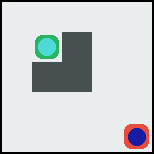

In [66]:
# Вывод структуры каждого дерева
paths = [extract_path(tree, task_map, []) for tree in trees]
draw(task_map,task_map,starts,goals,paths)


# Тестирование

In [52]:
import pickle
with open("test_data.pkl", "rb") as f:
  test_data = pickle.load(f)

In [53]:
from tqdm import tqdm
troubels = []
for sample in tqdm(test_data):
  try:
    mask, test, starts, goals = sample
    right_paths = test_data[sample]
    mask_map = Map(convert_string_to_cells(mask))
    test_map = Map(convert_string_to_cells(test))
    u = set([tuple(pos) for pos in np.argwhere(mask_map._cells == 2)])
    c = set([tuple(pos) for pos in np.argwhere(mask_map._cells == 1)])
    trees = CEBC(mask_map, starts, goals, set([]), u)
    paths = []
    for tree in trees:
      paths.append(extract_path(tree, test_map, []))
    right_len = max(map(len,right_paths))
    max_len = max(map(len,paths))
    if not check_paths(starts, goals, paths) :
      print(f"Путь для {sample} некорректный")
      troubels.append(sample)
      continue
    if right_len < max_len:
      troubels.append(sample)
      print(f"Путь для {sample} длинее на {max_len - right_len}")
  except:
      print(f"Критическая ошибка в {sample}")
      troubels.append(sample)

  2%|▏         | 2/89 [00:20<14:33, 10.04s/it]

Путь для ('\n..#.#..\n..#.PP.\n.......\n#P#.#P#\n..#.P..\n....#.#\n..#....\n', '\n..#.#..\n..#....\n.......\n###.#.#\n..#....\n....#.#\n..#....\n', ((0, 1), (3, 3), (2, 5)), ((5, 2), (0, 5), (1, 3))) длинее на 1


 31%|███▏      | 28/89 [01:34<02:24,  2.37s/it]

3
[(0, 6), (1, 6), (2, 6), (2, 5), (2, 4), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (6, 6)]
Путь для ('\n..#.#..\n..#.PP.\n.......\n#P#.#P#\n..#.P..\n....#.#\n..#....\n', '\n..#.#..\n..#..#.\n.......\n###.###\n..#.#..\n....#.#\n..#....\n', ((3, 3), (6, 1), (5, 2), (0, 6)), ((2, 5), (0, 3), (4, 5), (6, 6))) некорректный:/
Путь для ('\n.......\n##.#PP#\n.P.....\n.#..#..\n....#..\n....P..\n#P#.#..\n....#..\n', '\n.......\n##.#..#\n.#.....\n.#..#..\n....#..\n....#..\n#.#.#..\n....#..\n', ((6, 5), (4, 0), (3, 0), (5, 5)), ((2, 3), (0, 1), (5, 3), (3, 2))) некорректный:/
1
[(2, 3), (3, 3), (3, 2), (4, 2), (5, 2), (6, 2), (6, 1), (6, 0)]
Путь для ('\n.#.....\n.#.#P##\n.......\n.#..#..\n.P.##P#\n.#.....\n.P..#..\n', '\n.#.....\n.#.####\n.......\n.#..#..\n.#.####\n.#.....\n....#..\n', ((5, 6), (2, 3)), ((1, 0), (6, 0))) некорректный:/
Путь для ('\n.......\n##.#PP#\n.P.....\n.#..#..\n....#..\n....P..\n#P#.#..\n....#..\n', '\n.......\n##.####\n.#.....\n.#..#..\n....#..\n....#..\n##

 57%|█████▋    | 51/89 [01:35<00:40,  1.07s/it]

Путь для ('\n.......\n##.#PP#\n.P.....\n.#..#..\n....#..\n....P..\n#P#.#..\n....#..\n', '\n.......\n##.##.#\n.#.....\n.#..#..\n....#..\n.......\n#.#.#..\n....#..\n', ((3, 0), (3, 6)), ((0, 4), (2, 4))) длинее на 2
Путь для ('\n.......\n##.#PP#\n.P.....\n.#..#..\n....#..\n....P..\n#P#.#..\n....#..\n', '\n.......\n##.##.#\n.......\n.#..#..\n....#..\n....#..\n###.#..\n....#..\n', ((4, 3), (3, 2)), ((0, 1), (7, 2))) длинее на 2
Путь для ('\n.#.....\n.#.#P##\n.......\n.#..#..\n.P.##P#\n.#.....\n.P..#..\n', '\n.#.....\n.#.#.##\n.......\n.#..#..\n.#.####\n.#.....\n.#..#..\n', ((3, 2), (6, 2), (5, 4)), ((6, 0), (1, 0), (2, 2))) некорректный:/
1
[(1, 0), (2, 0), (2, 1), (2, 2), (1, 2)]
Путь для ('\n.#.....\n.#.#P##\n.......\n.#..#..\n.P.##P#\n.#.....\n.P..#..\n', '\n.#.....\n.#.####\n.......\n.#..#..\n...##.#\n.#.....\n....#..\n', ((2, 5), (1, 0), (6, 3)), ((0, 5), (1, 2), (5, 2))) некорректный:/
2
[(0, 3), (1, 3), (2, 3), (2, 2), (2, 1)]
Путь для ('\n..#.#..\n..#.PP.\n.......\n#P#.#P#\n..#.P..

100%|██████████| 89/89 [01:46<00:00,  1.19s/it]

Путь для ('\n..#.#..\n..#.PP.\n.......\n#P#.#P#\n..#.P..\n....#.#\n..#....\n', '\n..#.#..\n..#....\n.......\n#.#.###\n..#.#..\n....#.#\n..#....\n', ((0, 6), (1, 0)), ((6, 4), (2, 5))) длинее на 2
Путь для ('\n..#.#..\n..#.PP.\n.......\n#P#.#P#\n..#.P..\n....#.#\n..#....\n', '\n..#.#..\n..#.##.\n.......\n###.###\n..#.#..\n....#.#\n..#....\n', ((2, 6), (5, 0)), ((4, 0), (1, 1))) некорректный:/
1
[(5, 0), (5, 1), (5, 2), (5, 3), (4, 3), (3, 3), (2, 3), (2, 4), (2, 5), (3, 5)]
Путь для ('\n.......\n##.#PP#\n.P.....\n.#..#..\n....#..\n....P..\n#P#.#..\n....#..\n', '\n.......\n##.#.##\n.......\n.#..#..\n....#..\n....#..\n###.#..\n....#..\n', ((0, 1), (5, 0)), ((7, 3), (3, 5))) некорректный:/
Путь для ('\n.......\n##.#PP#\n.P.....\n.#..#..\n....#..\n....P..\n#P#.#..\n....#..\n', '\n.......\n##.#..#\n.......\n.#..#..\n....#..\n.......\n###.#..\n....#..\n', ((5, 5), (0, 5), (0, 2), (2, 2)), ((2, 6), (4, 1), (4, 6), (7, 0))) длинее на 2
2
[(2, 2), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), 